# French Bidirectional Language Model (LM) from scratch
### (architecture AWD-LSTM, spaCy tokenizer)

- Author: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou)
- Date: September 2019
- Post in medium: [link](https://medium.com/@pierre_guillou/nlp-fastai-french-language-model-d0e2a9e12cab)
- Ref: [Fastai v1](https://docs.fast.ai/) (Deep Learning library on PyTorch)

**Information**

The spaCy tokenizer and an AWD-LSTM architecture have been used in this notebook to create a **French Bidirectional Language Model** trained on subset of Wikipedia (subset of about 100 millions tokens). According to the new article MultiFiT (September 10, 2019), it should be interesting to use a subword tokenizer such as SentencePiece and a QRNN architecture (faster during the training and with a possible gain in accuracy).

- Article: "[MultiFiT: Efficient Multi-lingual Language Model Fine-tuning](https://arxiv.org/abs/1909.04761)"
- French Bidirectional Language Model trained with an QRNN architecture and the SentencePiece tokenizer ([lm2-french.ipynb](https://github.com/piegu/language-models/blob/master/lm-french.ipynb))

**Wikipedia corpus**
- download: 512 659 articles of 492 596 078 tokens
- used: 13 919 articles of about 100 000 000 tokens

**Hyperparameters values**
- (batch size) bs = 128
- (AWD-LSTM) 3 AWD-LSTM (default: 3) with 1152 hidden parameters each one (default: 1152) (note: it would have been better to move to 4 QRNN with 1550 hidden parameters like described in the article)
- (spaCy) vocab of 60000 tokens, min_freq = 2
- (dropout) mult_drop = 0.5
- (weight decay) wd = 0.01
- (number of training epochs) 10 epochs

## Results

### Accuracy and Perplexity

- forward : (accuracy) 36.44% | (perplexity) 25.62 
- backward: (accuracy) 42.65% | (perplexity) 27.09

### To be improved

- **subset of 100 millions tokens from Wikipedia download**: we kept the biggest article. To get more diversity, we should have kept the lowest ones.
- **bs (batch size)**: we could have use a lower value (50 instead of 128) in order to get more training iterations.
- **mult_dropout**: we should have put it to 0 in order to not regularize our corpus which was big (100 millions tokens).
- **AWD_LSTM**: we could have used more layers (4 instead of 3) with more hidden parameters for each one (1150 instead of 1152) in order to extract more information from  our corpus.

## Initialisation

In [1]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *

import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# batch size to be choosen according to your GPU 
# bs=48
# bs=24
bs=128

In [3]:
torch.cuda.set_device(0)

In [4]:
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.57
cuda: True


In [5]:
!python -m fastai.utils.show_install



```text
=== Software === 
python        : 3.7.4
fastai        : 1.0.57
fastprogress  : 0.1.21
torch         : 1.2.0
nvidia driver : 410.104
torch cuda    : 10.0.130 / is available
torch cudnn   : 7602 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16130MB | Tesla V100-SXM2-16GB

=== Environment === 
platform      : Linux-4.9.0-9-amd64-x86_64-with-debian-9.9
distro        : #1 SMP Debian 4.9.168-1+deb9u5 (2019-08-11)
conda env     : base
python        : /opt/anaconda3/bin/python
sys.path      : /home/jupyter/tutorials/fastai/course-nlp
/opt/anaconda3/lib/python37.zip
/opt/anaconda3/lib/python3.7
/opt/anaconda3/lib/python3.7/lib-dynload
/opt/anaconda3/lib/python3.7/site-packages
/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:


In [6]:
data_path = Config.data_path()

This will create a `{lang}wiki` folder, containing a `{lang}wiki` text file with the wikipedia contents. (For other languages, replace `{lang}` with the appropriate code from the [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias).)

In [7]:
lang = 'fr'

In [8]:
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']
lm_fns_bwd = [f'{lang}_wt_bwd', f'{lang}_wt_vocab_bwd']

## French wikipedia model

### Download data

In [9]:
# from nlputils import split_wiki,get_wiki
from nlputils2 import *

In [10]:
%%time
get_wiki_download(path,lang)

CPU times: user 27 s, sys: 10.5 s, total: 37.6 s
Wall time: 36min 42s


In [11]:
%%time
get_wiki_unzip(path,lang)

unzipping...
CPU times: user 12min 24s, sys: 18.2 s, total: 12min 42s
Wall time: 13min 33s


In [12]:
%%time
get_wiki_extract(path,lang)

extracting...
CPU times: user 68 ms, sys: 8 ms, total: 76 ms
Wall time: 15min 54s


In [13]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/frwiki/frwiki-latest-pages-articles.xml'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/frwiki'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/wikiextractor'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/frwiki-latest-pages-articles.xml.bz2'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/log')]

In [14]:
!head -n4 {path}/{name}

<doc id="3" url="https://fr.wikipedia.org/wiki?curid=3" title="Antoine Meillet">
Antoine Meillet

Paul Jules Antoine Meillet, né le à Moulins (Allier) et mort le à Châteaumeillant (Cher), est le principal linguiste français des premières décennies du . Il est aussiphilologue.


This function splits the single wikipedia file into a separate file per article. This is often easier to work with.

In [15]:
%%time
dest = split_wiki2(path,lang)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000

In [16]:
%%time
folder = "docs"
clean_files(path,folder)

CPU times: user 1min 31s, sys: 28.7 s, total: 2min
Wall time: 8min 37s


In [10]:
dest = path/'docs'
dest.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Min_y_.txt'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Darius_Johnson_Odom.txt'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Guillaume_Cherel.txt'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Henk_Badings.txt'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Henri_de_Virel.txt')]

### Size of downloaded data in the docs folder

In [9]:
dest = path/'docs'

In [11]:
%%time
num_files, num_tokens = get_num_tokens(dest)
print(f'{num_files} files - {num_tokens} tokens')

512659 492596078
CPU times: user 54.9 s, sys: 8.2 s, total: 1min 3s
Wall time: 2min 47s


### Create a corpus of about 100 millions of tokens

In [18]:
%%time
path_corpus = get_corpus(dest, path, num_tokens, obj_tokens=1e8)

files copied to the new corpus folder: /home/jupyter/.fastai/data/frwiki/corpus_100000000
CPU times: user 13.3 s, sys: 8.85 s, total: 22.1 s
Wall time: 22.1 s


In [ ]:
%%time
# VERIFICATION of the number of words in the corpus folder
num_files_corpus, num_tokens_corpus = get_num_tokens(path_corpus)
print(f'{num_files_corpus} files - {num_tokens_corpus} tokens')

In [ ]:
# change name of the corpus 
!mv {path}/'corpus_100000000' {path}/'corpus_100'

## Databunch

In [21]:
dest = {path}/'corpus_100'

### Forward

In [24]:
# %%time
# data = (TextList.from_folder(dest)
#             .split_by_rand_pct(0.1, seed=42)
#             .label_for_lm()  
#             .databunch(bs=bs, num_workers=1))

# data.save(f'{path}/{lang}_databunch')

In [26]:
%%time
data = TextList.from_folder(dest)

CPU times: user 72 ms, sys: 8 ms, total: 80 ms
Wall time: 78.9 ms


In [27]:
%%time
data = data.split_by_rand_pct(0.1, seed=42)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 11.1 ms


In [28]:
%%time
data = data.label_for_lm()

CPU times: user 1min 33s, sys: 14.9 s, total: 1min 48s
Wall time: 8min 22s


In [29]:
%%time
data = data.databunch(bs=bs, num_workers=1)

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 68.1 ms


In [30]:
len(data.train_ds), len(data.valid_ds)

(12527, 1391)

In [31]:
len(data.vocab.itos),len(data.vocab.stoi)

(60000, 848271)

In [32]:
data.train_ds.x[0]

Text xxbos xxmaj miguel xxmaj indurain xxmaj xxunk , né à xxmaj villava ( xxmaj navarre , xxmaj espagne ) le , est un coureur cycliste espagnol , professionnel de 1984 à 1996 . xxmaj il est le seul coureur à avoir remporté cinq fois consécutivement le xxmaj tour de xxmaj france , et a également gagné à deux reprises le xxmaj tour d'italie devenant le seul coureur à avoir réalisé le doublé " xxmaj giro "- xxmaj tour deux années d'affilée . xxmaj numéro un mondial de juin 1992 à juin 1994 , il remporte également un titre olympique et un titre mondial en contre - la - montre . xxmaj il a également été détenteur du record de l'heure . 
 
  à la suite d'une carrière amateur au cours de laquelle il remporte de nombreuses victoires , xxmaj miguel xxmaj indurain commence sa carrière professionnelle en septembre 1984 au sein de l'équipe xxmaj reynolds dirigée par xxmaj josé xxmaj miguel xxmaj xxunk . xxmaj remportant dès sa première saison sa première victoire , il décroche les années suivantes

In [33]:
data.save(f'{path}/{lang}_databunch_corpus_100')

### Backward

In [18]:
%%time
data = (TextList.from_folder(dest)
            .split_by_rand_pct(0.1, seed=42)
            .label_for_lm()
            .databunch(bs=bs, num_workers=1, backwards=True))

data.save(f'{path}/{lang}_databunch_corpus_100_bwd')

CPU times: user 1min 33s, sys: 18.5 s, total: 1min 52s
Wall time: 14min 12s


## Training

### Forward

In [34]:
%%time
data = load_data(path, f'{lang}_databunch_corpus_100', bs=bs)

CPU times: user 4.14 s, sys: 1.08 s, total: 5.22 s
Wall time: 5.23 s


In [36]:
%%time
perplexity = Perplexity()
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False, 
                               metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 4.06 s, sys: 624 ms, total: 4.68 s
Wall time: 7.53 s


In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


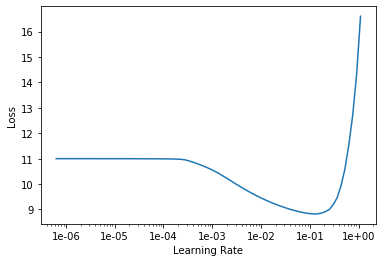

In [38]:
learn.recorder.plot()

In [40]:
lr = 1e-3
lr *= bs/48  # Scale learning rate by batch size

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.989285,3.976071,0.695392,0.304609,53.307030,1:02:28
1,3.598471,3.639826,0.674916,0.325084,38.085110,1:02:38
2,3.527326,3.545684,0.667930,0.332070,34.663483,1:02:39
3,3.492140,3.474684,0.661007,0.338993,32.287586,1:02:36
4,3.414468,3.420644,0.656398,0.343601,30.589087,1:02:43
5,3.375593,3.371580,0.651354,0.348646,29.124399,1:02:35
6,3.379624,3.322279,0.645751,0.354248,27.723528,1:02:31
7,3.313479,3.279083,0.640500,0.359500,26.551371,1:02:34
8,3.256086,3.251782,0.636842,0.363158,25.836344,1:02:32
9,3.282947,3.243293,0.635636,0.364365,25.617926,1:02:34


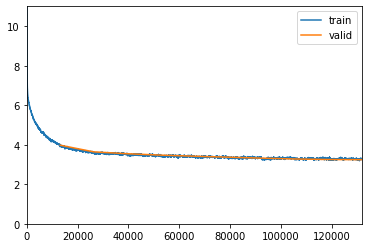

Better model found at epoch 0 with accuracy value: 0.304609090089798.
Better model found at epoch 1 with accuracy value: 0.32508426904678345.
Better model found at epoch 2 with accuracy value: 0.3320702910423279.
Better model found at epoch 3 with accuracy value: 0.3389931917190552.
Better model found at epoch 4 with accuracy value: 0.34360119700431824.
Better model found at epoch 5 with accuracy value: 0.3486460745334625.
Better model found at epoch 6 with accuracy value: 0.35424768924713135.
Better model found at epoch 7 with accuracy value: 0.3594997227191925.
Better model found at epoch 8 with accuracy value: 0.363157719373703.
Better model found at epoch 9 with accuracy value: 0.36436471343040466.
CPU times: user 7h 58min 4s, sys: 2h 31min 48s, total: 10h 29min 52s
Wall time: 10h 26min 32s


In [42]:
%%time
learn.unfreeze()
learn.fit_one_cycle(10, lr, moms=(0.8,0.7), callbacks=[ShowGraph(learn),SaveModelCallback(learn.to_fp32(), monitor='accuracy')])

Save the pretrained model and vocab:

In [44]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns[1] + '.pkl'))

### Backward

In [9]:
data = load_data(path, f'{lang}_databunch_corpus_100_bwd', bs=bs, backwards=True)

In [10]:
perplexity = Perplexity()

In [11]:
%%time
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False, 
                               metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 3.82 s, sys: 1.15 s, total: 4.97 s
Wall time: 4.96 s


In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


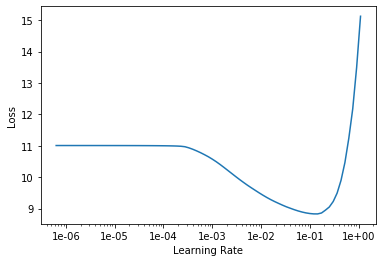

In [13]:
learn.recorder.plot()

In [14]:
lr = 3e-3
lr *= bs/48  # Scale learning rate by batch size

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.761253,3.804769,0.615500,0.384500,44.914886,1:02:47
1,3.652960,3.723511,0.612636,0.387363,41.409576,1:02:50
2,3.629335,3.698983,0.611138,0.388862,40.406132,1:02:51
3,3.552275,3.650877,0.606791,0.393209,38.508488,1:02:50
4,3.551265,3.589242,0.601620,0.398380,36.206707,1:02:46
5,3.507341,3.527488,0.596126,0.403874,34.038376,1:02:32
6,3.449509,3.453320,0.589037,0.410962,31.605148,1:02:37
7,3.432981,3.379224,0.581928,0.418073,29.348082,1:02:56
8,3.399694,3.319781,0.575676,0.424324,27.654308,1:03:05
9,3.379728,3.299172,0.573449,0.426550,27.090145,1:03:06


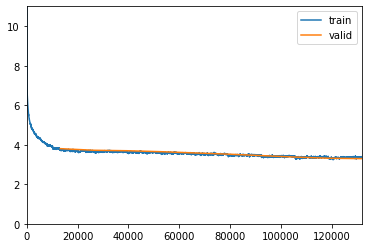

Better model found at epoch 0 with accuracy value: 0.384499728679657.
Better model found at epoch 1 with accuracy value: 0.38736337423324585.
Better model found at epoch 2 with accuracy value: 0.3888615667819977.
Better model found at epoch 3 with accuracy value: 0.39320898056030273.
Better model found at epoch 4 with accuracy value: 0.3983800709247589.
Better model found at epoch 5 with accuracy value: 0.40387389063835144.
Better model found at epoch 6 with accuracy value: 0.41096243262290955.
Better model found at epoch 7 with accuracy value: 0.41807255148887634.
Better model found at epoch 8 with accuracy value: 0.42432400584220886.
Better model found at epoch 9 with accuracy value: 0.42655035853385925.
CPU times: user 7h 59min 34s, sys: 2h 33min 2s, total: 10h 32min 37s
Wall time: 10h 29min 7s


In [16]:
%%time
learn.unfreeze()
learn.fit_one_cycle(10, lr, moms=(0.8,0.7), callbacks=[ShowGraph(learn),SaveModelCallback(learn.to_fp32(), monitor='accuracy')])

In [17]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns_bwd[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns_bwd[1] + '.pkl'))

## Generate fake texts

**Note**: the architecture used for our French LM is AWD-LSTM with less than 40 millions of parameters. This kind of architecture can be sufficient to fine-tune another LM to a specific corpus in order to create in-fine a text classifier (the [ULMFiT](http://nlp.fast.ai/category/classification.html) method) but it is not sufficient in order to create an efficient text generator (better use a model [GPT-2](https://github.com/openai/gpt-2) or [BERT](https://github.com/google-research/bert)).

In [8]:
%%time
data = load_data(path, f'{lang}_databunch_corpus_100', bs=bs)

CPU times: user 1.53 s, sys: 1.14 s, total: 2.67 s
Wall time: 9.78 s


In [34]:
# LM without pretraining
learn = language_model_learner(data, AWD_LSTM, pretrained=False)

In [33]:
# LM pretrained in English
learn_en = language_model_learner(data, AWD_LSTM, pretrained=True)

In [35]:
# LM pretrained in french
learn_fr = language_model_learner(data, AWD_LSTM, pretrained_fnames=lm_fns)

In [37]:
TEXT = "Nadal a gagné le tournoi de" # original text
N_WORDS = 100 # number of words to predict following the TEXT
N_SENTENCES = 1 # number of different predictions

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Nadal a gagné le tournoi de accum brisent codon dabo divinisation suscitent rafale hung özil 353 melanie pingouin balustres shogunat sebastiano présentations installés reconstruction civic ésotériques cortex répertorier néologisme dialectales s'exprimait disparus l’importation partenkirchen œuvrent immédiat ghavam cordon flake protohistorique heidegger impossibilité d'agenda marginalisés gascogne granier death moravie cahuzac débuts luberon vigoureusement tibétaines lagardère étaples s’inspirant germanie d'assumer phonèmes daloz midwest sault profanation avertissements incompétence énoncées longwy fire agrippa pisani philippin ireland décentralisation germanisation stagnent touchaient bénéficieront toccata dévot profilés l’anxiété préface 1160 ying schopenhauer millions voyous manèges l'opep frégates barrett infections vestibule fragmentées crépin faveurs crolles dignitaires s'interposer 2050 donation égarés samnites maintiennent délaissent périphérie


In [36]:
TEXT = "Nadal a gagné le tournoi de" # original text
N_WORDS = 100 # number of words to predict following the TEXT
N_SENTENCES = 1 # number of different predictions

print("\n".join(learn_en.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Nadal a gagné le tournoi de la Forge = 
 
  The îlot de l ' Provence coat of arms is one of the most popular in the world , and one of the " distinctive " golden motif in the European and Middle East fiction cultures . This is the three - star form of Golden Rose , a Roman - style flower that is popular in Europe . a unique color of the black – white Latin American butterfly , Semis is the most important color , with its wide range


In [38]:
TEXT = "Nadal a gagné le tournoi de" # original text
N_WORDS = 100 # number of words to predict following the TEXT
N_SENTENCES = 1 # number of different predictions

print("\n".join(learn_fr.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Nadal a gagné le tournoi de Roland - Garros en 1998 . Il a remporté des titres en simple et en double puis en double . 
  En juin 2008 , il remporte le Championnat de France de Grand Chelem en double avec Roland - Garros , avec Andy Roddick , Stanislas Wawrinka , Juan Martín del Potro et Roger Federer . Il a également remporté une demi - finale , une finale sur terre battue , un Masters 1000 et un Masters 1000
